# Semi-supervised image classification using local label propagation

Name:

UW Email:

# Abstract

TODO


# Team members & contributions

TODO

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
import torchvision.datasets as datasets
from torchvision.models import ResNet18_Weights

from sklearn.cluster import KMeans

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
np.random.seed(42)

In [4]:
# TODO: create more datasets

UNLABELLED = -1

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

# Load CIFAR-10 datasets
cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_valid = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def generate_indices(dataset, pct_labelled=0.1):
    num_samples = int(pct_labelled * len(dataset))
    return torch.randperm(len(dataset))[:num_samples]



# Define datasets for fully supervised learning

# 10% of data labelled
indices_10 = generate_indices(cifar_train, 0.1)
full_dataset_10 = torch.utils.data.Subset(cifar_train, indices_10)
full_loader_10 = DataLoader(full_dataset_10, batch_size=128, shuffle=True, num_workers=2)

# 5% of data labelled
indices_05 = generate_indices(cifar_train, 0.05)
full_dataset_05 = torch.utils.data.Subset(cifar_train, indices_05)
full_loader_05 = DataLoader(full_dataset_05, batch_size=128, shuffle=True, num_workers=2)

# 25% of data labelled
indices_25 = generate_indices(cifar_train, 0.25)
full_dataset_25 = torch.utils.data.Subset(cifar_train, indices_25)
full_loader_25 = DataLoader(full_dataset_25, batch_size=128, shuffle=True, num_workers=2)

loader_valid = DataLoader(cifar_valid, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 78431548.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) # initialize weights to make training easier (via transfer learning)
        self.model.fc = nn.Identity()
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        features = self.model(x)
        x = self.fc(features)
        return x, features

# Supervised learning

We want to see how well we can do without using the unlabelled data points at all, with a simple supervised model only on that subset of data. This will be the baseline against which we will compare. As stated earlier, we will do this with subsets of labelled data comprising 1%, 5%, and 10% of the data.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


models = [Model() for i in range(3)]
names = ["25% labelled", "5% labelled", "10% labelled"]
data_loaders = [full_loader_25, full_loader_05, full_loader_10]
losses = [[] for i in range(3)]

for model_idx in range(3):
    criterion = nn.CrossEntropyLoss()

    full_model = models[model_idx]

    full_model.train()
    full_model.to(device)

    optimizer = torch.optim.SGD(full_model.parameters(), lr=0.001, momentum=0.9)
    num_epochs = 5

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(tqdm(data_loaders[model_idx])):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs, features = full_model(images)

            loss = criterion(outputs, labels)
            losses[model_idx].append(loss.item())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print statistics
        print(f"{names[model_idx]} -- Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")



  0%|          | 0/98 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 98/98 [00:39<00:00,  2.50it/s]


25% labelled -- Epoch 1/5, Loss: 0.7079


100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


25% labelled -- Epoch 2/5, Loss: 0.4516


100%|██████████| 98/98 [00:44<00:00,  2.21it/s]


25% labelled -- Epoch 3/5, Loss: 0.3191


100%|██████████| 98/98 [00:44<00:00,  2.19it/s]


25% labelled -- Epoch 4/5, Loss: 0.2583


100%|██████████| 98/98 [00:39<00:00,  2.45it/s]


25% labelled -- Epoch 5/5, Loss: 0.1470


100%|██████████| 20/20 [00:07<00:00,  2.51it/s]


5% labelled -- Epoch 1/5, Loss: 1.9391


100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


5% labelled -- Epoch 2/5, Loss: 1.4959


100%|██████████| 20/20 [00:08<00:00,  2.30it/s]


5% labelled -- Epoch 3/5, Loss: 1.0096


100%|██████████| 20/20 [00:08<00:00,  2.41it/s]


5% labelled -- Epoch 4/5, Loss: 0.7878


100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


5% labelled -- Epoch 5/5, Loss: 0.5180


100%|██████████| 40/40 [00:15<00:00,  2.60it/s]


10% labelled -- Epoch 1/5, Loss: 1.4469


100%|██████████| 40/40 [00:15<00:00,  2.58it/s]


10% labelled -- Epoch 2/5, Loss: 0.7835


100%|██████████| 40/40 [00:15<00:00,  2.62it/s]


10% labelled -- Epoch 3/5, Loss: 1.2853


100%|██████████| 40/40 [00:15<00:00,  2.61it/s]


10% labelled -- Epoch 4/5, Loss: 1.1441


100%|██████████| 40/40 [00:15<00:00,  2.62it/s]

10% labelled -- Epoch 5/5, Loss: 0.8316


Text(0.5, 1.0, 'Supervised training loss- 10%')

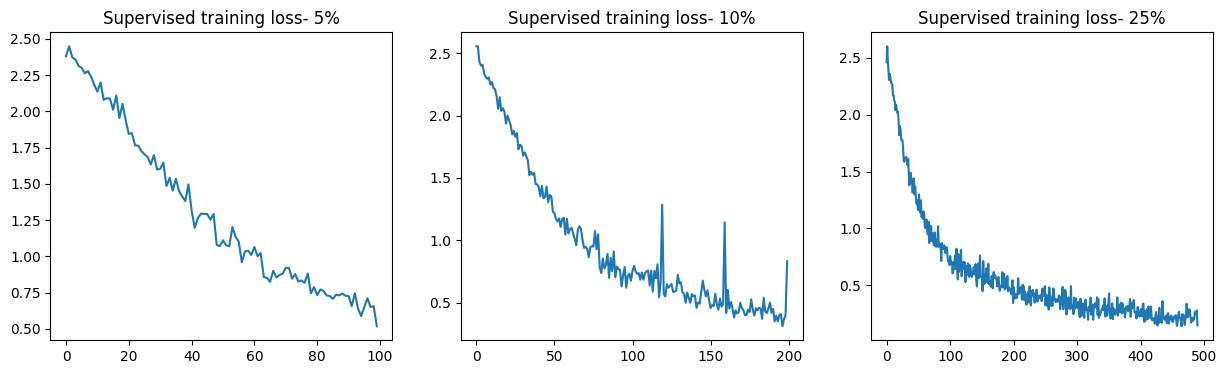

In [ ]:
fig = plt.figure(figsize=(15,4))

plt.subplot(133)
plt.plot(losses[0], label=names[0])
plt.title('Supervised training loss- 25%')
plt.subplot(131)
plt.plot(losses[1], label=names[1])
plt.title('Supervised training loss- 5%')

plt.subplot(132)
plt.plot(losses[2], label=names[2])
plt.title('Supervised training loss- 10%')


In [6]:
# Returns fraction of correct predictions of the model on the given dataset
def evaluate_model(model, data_loader):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs, _ = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
# Evaluate the models
for model_idx in range(3):
    pct_correct_supervised_trained = 100 * evaluate_model(models[model_idx], loader_valid)
    print(f"Accuracy of the supervised model trained on {names[model_idx]} of labels: {pct_correct_supervised_trained} %")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the supervised model trained on 25% labelled of labels: 89.03999999999999 %
Accuracy of the supervised model trained on 5% labelled of labels: 73.89 %
Accuracy of the supervised model trained on 10% labelled of labels: 83.21 %


Of course, we expect an untrained model to be right around 10% of the time, as there are 10 classes.

In [ ]:
# Compared to untrained model

untrained_model = Model()
untrained_model.eval()
untrained_model.to(device)

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = untrained_model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of an untrained model : %d %%' % (100 * correct / total))


Accuracy of an untrained model : 10 %


# Semi-supervised learning

In [7]:
# Custom dataset for semi-supervised learning
class SemiSupervised(torch.utils.data.Dataset):
    def __init__(self, labeled_dataset, indices):
        self.labeled_dataset = labeled_dataset
        self.labeled_indices = indices

    def __getitem__(self, index):
        if index in self.labeled_indices:
            return self.labeled_dataset[index]
        else:
            img, label = self.labeled_dataset[index]
            return img, UNLABELLED

    def __len__(self):
        return len(self.labeled_dataset)

# Create semi-supervised datasets
semi_dataset_10 = SemiSupervised(
    labeled_dataset=cifar_train,
    indices=indices_10
)

semi_dataset_05 = SemiSupervised(
    labeled_dataset=cifar_train,
    indices=indices_05
)

semi_dataset_25 = SemiSupervised(
    labeled_dataset=cifar_train,
    indices=indices_25
)

semi_loader_10 = DataLoader(semi_dataset_10, batch_size=128, shuffle=True, num_workers=2)
semi_loader_05 = DataLoader(semi_dataset_05, batch_size=128, shuffle=True, num_workers=2)
semi_loader_25 = DataLoader(semi_dataset_25, batch_size=128, shuffle=True, num_workers=2)

In [8]:
# non-parametric softmax operation by Wu et. al.
# axis 0: v, axis 1: i
def PIV(features, temp):
  upper = torch.exp(torch.matmul(features, features.T) / temp)
  denom = upper.sum(axis=1)
  return upper / denom

def weighted_knn(features, labels, k, temp):
  # Calculate the distances between each pair of points
    mask = torch.where(labels == UNLABELLED)
    unlabelled_features = (features[mask])
    labelled_features = features[labels != UNLABELLED]
    only_labels = labels[labels != UNLABELLED]

    distances = torch.cdist(unlabelled_features, labelled_features, p=2)

    # Find the k nearest neighbors for each point in x
    _, indices = torch.topk(distances, k=min(k, len(only_labels)), largest=False)

    piv = PIV(features, temp)

    weights = torch.zeros((len(mask[0]), 10))
    weights = weights.to(device)

    for i, idxs in enumerate(indices):
      v = mask[0][i]
      for j in idxs:
        weights[i][only_labels[j]] += piv[v, j]

    probs = weights / weights.sum(axis=1)[:, None]

    pseudo_confidence, pseudo_labels = probs.max(axis=1)

    pseudo_labels = pseudo_labels.to(device)
    pseudo_confidence = pseudo_confidence.to(device)

    new_labels = labels.clone()
    new_labels[mask] = pseudo_labels

    confidence = torch.ones_like(labels, dtype=pseudo_confidence.dtype)
    confidence[mask] = pseudo_confidence

    return new_labels, confidence



In [9]:
class KMeansClusteringLoss(torch.nn.Module):
    def __init__(self):
        super(KMeansClusteringLoss, self).__init__()

    def forward(self, features, centroids):
        n = features.shape[0]
        d = features.shape[1]
        k = centroids.shape[0]

        z = features.reshape(n, 1, d)
        z = z.repeat(1, k, 1)

        mu = centroids.reshape(1, k, d)
        mu = mu.repeat(n, 1, 1)

        dist = (z - mu).norm(2, dim=2).reshape((n, k))
        loss = (dist.min(dim=1)[0] ** 2)

        return loss

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')
clustering_criterion = KMeansClusteringLoss()

semi_model_10 = Model()

semi_model_10.train()
semi_model_10.to(device)

optimizer = torch.optim.SGD(semi_model_10.parameters(), lr=0.0001, momentum=0.9)
ALPHA = 0.01 # hyper parameter controlling weight of cluster loss
NUM_EPOCHS = 5
K = 10
TEMP = 25

losses = []

for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(tqdm(semi_loader_10)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs, features = semi_model_10(images)

        # pseudo-labelling
        pseudo_labels, confidence = weighted_knn(features, labels, K, TEMP)

        # loss calculation
        centroids = KMeans(n_clusters=10, n_init=10).fit(features.cpu().detach().numpy()).cluster_centers_
        centroids = torch.tensor(centroids).to(device)
        cluster_loss = ALPHA * clustering_criterion(features, centroids)

        # print('CLUSTER LOSS: ', cluster_loss.mean().item())

        ce_loss = criterion(outputs, pseudo_labels)

        # print('CE LOSS: ', ce_loss.mean().item())

        loss = (confidence * (ce_loss + cluster_loss)).mean()
        losses.append(loss.item())

        # Backward pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print statistics
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {loss.item():.4f}")



  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [05:31<00:00,  1.18it/s]


Epoch 1/10, Loss: 1.7275


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [05:43<00:00,  1.38it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [05:44<00:00,  1.14it/s]


Epoch 2/10, Loss: 1.0891


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:16<00:00,  1.04it/s]


Epoch 3/10, Loss: 1.0643


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [05:52<00:00,  1.11it/s]


Epoch 4/10, Loss: 0.9818


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:08<00:00,  1.32it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:08<00:00,  1.06it/s]

Epoch 5/10, Loss: 0.7887


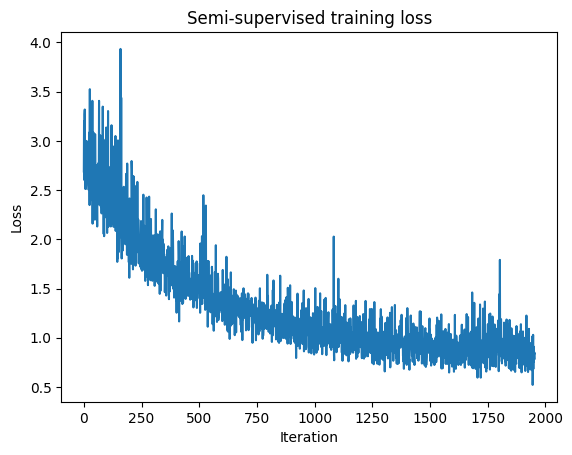

In [ ]:
plt.plot(losses)
plt.title('Semi-supervised training loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()


In [ ]:
# Evaluate the model
semi_model_10.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = semi_model_10(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the semi-supervised trained model: %d %%' % (100 * correct / total))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the semi-supervised trained model: 17 %


## Local Linear Propagation


In [31]:
def LLP_pv(features, labels, k, T, temp, num_labels=10):
    # Calculate the distances between each pair of points
    mask = torch.where(labels == UNLABELLED)
    unlabelled_features = (features[mask])
    labelled_features = features[labels != UNLABELLED]
    only_labels = labels[labels != UNLABELLED]

    distances = torch.cdist(unlabelled_features, labelled_features, p=2)

    # Find the k nearest neighbors for each point in x
    # _, indices = torch.topk(distances, k=min(k, len(only_labels)), largest=False)

    # print(f"LLP indices (shape={indices.shape})")

    piv = PIV(features, temp)

    # weights[i, j] is the weight for pseudo-labelled vector i as class j
    weights = torch.zeros((len(mask[0]), num_labels)).to(device)

    # for i, idxs in enumerate(indices):
    #   v = mask[0][i]
    #   for j in idxs:
    #     rho_vi = 0

    #     weight_term = piv[v, j] / rho_vi
    #     weights[i][only_labels[j]] += weight_term

    # print(f"piv (shape={piv.shape})")

    rho = torch.zeros(len(unlabelled_features), device=device)
    _, T_nearest_indices = torch.topk(distances, k=min(max(T, K), len(only_labels)), largest=False)
    for vi, tn_to_v_idxs in enumerate(T_nearest_indices):
        for j in tn_to_v_idxs:
          rho[vi] += piv[vi, j]

    # print(f"llp rho (shape={rho.shape}): {rho}")

    # for v, v_indices in enumerate(indices):
    #     for j in range(num_labels):
    #         weight_term = 0
    #         for i in v_indices:
    #             if labels[i] == j:
    #                 weight_term += piv[v, i] / rho[v]
    #         weights[v, j] = weight_term
    #         weights[v, j] /= torch.sum(piv[v])

    for v, v_indices in enumerate(T_nearest_indices[:, :min(K, T_nearest_indices.shape[1])]):
        for j in v_indices:
            weights[v][only_labels[j]] += piv[v, j] / rho[v]

    # print(f"llp weights (shape={weights.shape}): {weights}")


    probs = weights / weights.sum(axis=1)[:, None]
    numerator = torch.exp(weights)
    # print(f"numerator (shape={numerator.shape})")
    denominator = torch.sum(numerator, axis=1)
    # print(f"denominator (shape={denominator.shape})")
    probs = (numerator.T / denominator).T
    # print(f"probs (shape={probs.shape}): {probs}")
    # print(f"probs[0] = {probs[0, :]}")

    pseudo_confidence, pseudo_labels = probs.max(axis=1)

    pseudo_labels = pseudo_labels.to(device)
    pseudo_confidence = pseudo_confidence.to(device)

    new_labels = labels.clone()
    new_labels[mask] = pseudo_labels

    confidence = torch.ones_like(labels, dtype=pseudo_confidence.dtype)
    confidence[mask] = pseudo_confidence

    return new_labels, confidence

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='none')
clustering_criterion = KMeansClusteringLoss()

semi_model_10 = Model()

semi_model_10.train()
semi_model_10.to(device)

optimizer = torch.optim.SGD(semi_model_10.parameters(), lr=0.0001, momentum=0.9)
ALPHA = 0.0001 # hyper parameter controlling weight of cluster loss
NUM_EPOCHS = 5
K = 5
T = 10
TEMP = 50

losses = []

for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(tqdm(semi_loader_10)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs, features = semi_model_10(images)

        # print(f"features: {features}")

        # pseudo-labelling
        # pseudo_labels, confidence = weighted_knn(features, labels, K, TEMP)

        pseudo_labels, confidence = LLP_pv(features, labels, K, T, TEMP, 10)

        # print(f"llp pseudolabels (shape={pseudo_labels.shape}): ", pseudo_labels)
        # print(f"llp confidence (shape={confidence.shape}): ", confidence)

        features_without_nan = np.nan_to_num(features.cpu().detach().numpy(), 0)

        # loss calculation
        centroids = KMeans(n_clusters=10, n_init=10).fit(features_without_nan).cluster_centers_
        centroids = torch.tensor(centroids).to(device)
        cluster_loss = ALPHA * clustering_criterion(features, centroids)

        # print('CLUSTER LOSS: ', cluster_loss.mean().item())

        ce_loss = criterion(outputs, pseudo_labels)

        # print('CE LOSS: ', ce_loss.mean().item())

        loss = (confidence * (ce_loss + cluster_loss)).mean()
        losses.append(loss.item())

        # Backward pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print statistics
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item():.4f}")



  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:42<00:00,  1.03s/it]


Epoch 1/10, Loss: 1.5929


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:33<00:00,  1.01s/it]


Epoch 2/10, Loss: 1.1152


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:31<00:00,  1.14it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:31<00:00,  1.00s/it]


Epoch 3/10, Loss: 1.0282


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:29<00:00,  1.00it/s]


Epoch 4/10, Loss: 1.0088


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:47<00:00,  1.04s/it]

Epoch 5/10, Loss: 0.9850


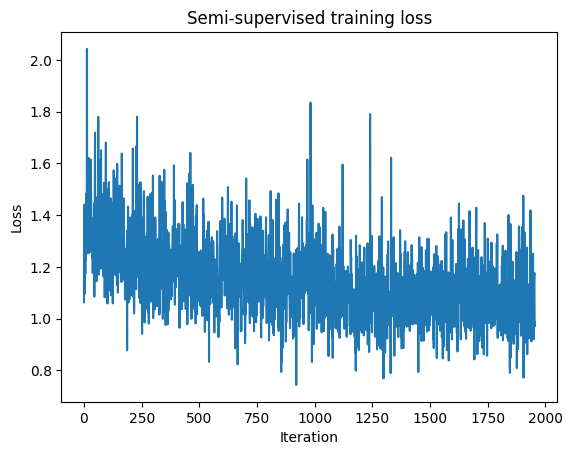

In [ ]:
plt.plot(losses)
plt.title('Semi-supervised training loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()


In [ ]:
pct_correct_supervised_trained = 100 * evaluate_model(semi_model_10, loader_valid)
print(f"Accuracy of the supervised model trained on 10% of labels: {pct_correct_supervised_trained} %")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the supervised model trained on 10% of labels: 30.81 %


In [ ]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(semi_model_10, f)

In [32]:
criterion = nn.CrossEntropyLoss(reduction='none')
clustering_criterion = KMeansClusteringLoss()

semi_model_05 = Model()

semi_model_05.train()
semi_model_05.to(device)

optimizer = torch.optim.SGD(semi_model_05.parameters(), lr=0.0001, momentum=0.9)
ALPHA = 0.0001 # hyper parameter controlling weight of cluster loss
NUM_EPOCHS = 5
K = 5
T = 10
TEMP = 50

losses = []

for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(tqdm(semi_loader_05)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs, features = semi_model_05(images)

        # print(f"features: {features}")

        # pseudo-labelling
        # pseudo_labels, confidence = weighted_knn(features, labels, K, TEMP)

        pseudo_labels, confidence = LLP_pv(features, labels, K, T, TEMP, 10)

        # print(f"llp pseudolabels (shape={pseudo_labels.shape}): ", pseudo_labels)
        # print(f"llp confidence (shape={confidence.shape}): ", confidence)

        # loss calculation
        centroids = KMeans(n_clusters=10, n_init=10).fit(features.cpu().detach().numpy()).cluster_centers_
        centroids = torch.tensor(centroids).to(device)
        cluster_loss = ALPHA * clustering_criterion(features, centroids)

        # print('CLUSTER LOSS: ', cluster_loss.mean().item())

        ce_loss = criterion(outputs, pseudo_labels)

        # print('CE LOSS: ', ce_loss.mean().item())

        loss = (confidence * (ce_loss + cluster_loss)).mean()
        losses.append(loss.item())

        # Backward pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print statistics
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item():.4f}")



  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:28<00:00,  1.10it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:28<00:00,  1.01it/s]


Epoch 1/10, Loss: 0.4729


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:28<00:00,  1.18it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:28<00:00,  1.01it/s]


Epoch 2/10, Loss: 0.4776


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:27<00:00,  1.21it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:27<00:00,  1.01it/s]


Epoch 3/10, Loss: 0.4344


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:34<00:00,  1.33s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:34<00:00,  1.01s/it]


Epoch 4/10, Loss: 0.4221


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:41<00:00,  1.03s/it]

Epoch 5/10, Loss: 0.5004


In [33]:
import pickle

with open('semi_model_05.pkl', 'wb') as f:
    pickle.dump(semi_model_05, f)

In [34]:
pct_correct_semi_05 = 100 * evaluate_model(semi_model_05, loader_valid)
print(f"Accuracy of the supervised model trained on 5% of labels: {pct_correct_semi_05} %")

print("losses: ", losses)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the supervised model trained on 5% of labels: 27.500000000000004 %


# finally we try LLP with 25% labelled

In [35]:
criterion = nn.CrossEntropyLoss(reduction='none')
clustering_criterion = KMeansClusteringLoss()

semi_model_25 = Model()

semi_model_25.train()
semi_model_25.to(device)

optimizer = torch.optim.SGD(semi_model_25.parameters(), lr=0.0001, momentum=0.9)
ALPHA = 0.0001 # hyper parameter controlling weight of cluster loss
NUM_EPOCHS = 5
K = 5
T = 10
TEMP = 50

losses = []

for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(tqdm(semi_loader_25)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs, features = semi_model_25(images)

        # print(f"features: {features}")

        # pseudo-labelling
        # pseudo_labels, confidence = weighted_knn(features, labels, K, TEMP)

        pseudo_labels, confidence = LLP_pv(features, labels, K, T, TEMP, 10)

        # print(f"llp pseudolabels (shape={pseudo_labels.shape}): ", pseudo_labels)
        # print(f"llp confidence (shape={confidence.shape}): ", confidence)

        # loss calculation
        centroids = KMeans(n_clusters=10, n_init=10).fit(features.cpu().detach().numpy()).cluster_centers_
        centroids = torch.tensor(centroids).to(device)
        cluster_loss = ALPHA * clustering_criterion(features, centroids)

        # print('CLUSTER LOSS: ', cluster_loss.mean().item())

        ce_loss = criterion(outputs, pseudo_labels)

        # print('CE LOSS: ', ce_loss.mean().item())

        loss = (confidence * (ce_loss + cluster_loss)).mean()
        losses.append(loss.item())

        # Backward pass

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print statistics
    print(f"Epoch {epoch+1}/{10}, Loss: {loss.item():.4f}")



100%|██████████| 391/391 [06:32<00:00,  1.00s/it]


Epoch 1/10, Loss: 0.6309


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:33<00:00,  1.01s/it]


Epoch 2/10, Loss: 0.6305


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:30<00:00,  1.00it/s]


Epoch 3/10, Loss: 0.5773


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:25<00:00,  1.01it/s]


Epoch 4/10, Loss: 0.4930


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 391/391 [06:26<00:00,  1.01it/s]

Epoch 5/10, Loss: 0.5006


In [36]:
import pickle

with open('semi_model_25.pkl', 'wb') as f:
    pickle.dump(semi_model_25, f)

In [ ]:
# TODO: import this model and do the evaluate_model and make the graphs

In [37]:
pct_correct_semi_25 = 100 * evaluate_model(semi_model_25, loader_valid)
print(f"Accuracy of the supervised model trained on 25% of labels: {pct_correct_semi_25} %")

print("losses: ", losses)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the supervised model trained on 25% of labels: 69.74000000000001 %
